In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# (En tu entorno local sí podrás importar TensorFlow)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Carga de datos (ajusta rutas si es necesario)
train = pd.read_csv("registros_entrenamiento-2.csv")
test  = pd.read_csv("registros_evaluacion-2.csv")

train.head()


/Users/cmta09/Desktop/Reto/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,IdPasajero,PlanetaOrigen,SuenoCriogenico,Cabina,Destino,Edad,ServicioVIP,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR,Transportado,Iniciales
0,004D8BSQ,NaN,False,C/268/S,TRAPPIST-1e,27.0,False,0.0,63.0,8.0,129.0,2960.0,False,YUW
1,009TL1XF,Europa,False,C/258/P,55 Cancri e,18.0,False,0.0,3492.0,0.0,506.0,8.0,True,SFW
2,00A9QC49,Europa,False,A/30/S,TRAPPIST-1e,44.0,True,1409.0,910.0,17.0,1452.0,3782.0,False,POY
3,00BJM5YI,Earth,False,E/24/P,TRAPPIST-1e,48.0,False,0.0,111.0,0.0,1508.0,0.0,False,ZIT
4,00DQRZAR,Mars,False,F/1550/P,TRAPPIST-1e,68.0,True,523.0,0.0,859.0,201.0,782.0,False,TJJ


La proporción de pasajeros transportados es cercana al 50%. Es decir, la anomalía afectó aproximadamente a la mitad de las personas, lo cual sugiere que no fue un evento extremadamente raro, sino algo relativamente “masivo” dentro del crucero.

In [2]:
train['Transportado'].value_counts(normalize=True)

Transportado
True     0.501625
False    0.498375
Name: proportion, dtype: float64

In [3]:
transport_rate_overall = train['Transportado'].mean()
rate_by_planet = train.groupby('PlanetaOrigen')['Transportado'].mean()
rate_by_cryo   = train.groupby('SuenoCriogenico')['Transportado'].mean()
rate_by_vip    = train.groupby('ServicioVIP')['Transportado'].mean()

print("Tasa global de transporte:", transport_rate_overall)
print("\nTasa por planeta de origen:\n", rate_by_planet)
print("\nTasa por sueño criogénico:\n", rate_by_cryo)
print("\nTasa por servicio VIP:\n", rate_by_vip)


Tasa global de transporte: 0.501625

Tasa por planeta de origen:
 PlanetaOrigen
Earth     0.421102
Europa    0.656504
Mars      0.523928
Name: Transportado, dtype: float64

Tasa por sueño criogénico:
 SuenoCriogenico
False    0.328884
True     0.814229
Name: Transportado, dtype: float64

Tasa por servicio VIP:
 ServicioVIP
False    0.503996
True     0.385475
Name: Transportado, dtype: float64


Pasajeros de Europa tienen más probabilidad de haber sido transportados → quizá sus cabinas estaban más cerca del reactor marciano o del punto de impacto.

Pasajeros en sueño criogénico tienen una probabilidad altísima de ser transportados (~81%) → tiene sentido narrativo: estaban conectados a sistemas de soporte vital avanzados, más expuestos a fluctuaciones de espacio-tiempo.

Pasajeros VIP parecen algo más protegidos (menor tasa de transporte), quizá porque sus cabinas tenían blindaje extra o estaban en zonas más interiores de la nave.

In [4]:
spend_cols = ['ServicioHabitacion','Cafeteria','CentroComercial','Spa','CubiertaVR']
train.groupby('Transportado')[spend_cols].mean()

,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR
Transportado,,,,,
False,382.837734,377.782575,165.660939,579.428352,545.98898
True,65.299644,544.171931,177.774169,63.071065,71.61213


Los transportados gastan mucho menos en casi todos los servicios (especialmente Spa, ServicioHabitacion, CubiertaVR), lo que cuadra con la idea de que muchos estaban dormidos en criogenia y no podían usar amenities.

In [18]:
def add_features(df):
    df = df.copy()
    
    # Cabina: cubierta / número / lado
    cabina_split = df['Cabina'].astype(str).str.split('/', expand=True)
    df['Cubierta']   = cabina_split[0].replace("nan", np.nan)
    df['NumCabina']  = pd.to_numeric(cabina_split[1], errors='coerce')
    df['LadoCabina'] = cabina_split[2].replace("nan", np.nan)
    
    # Total de gastos y bandera de ningún gasto
    spend_cols = ['ServicioHabitacion','Cafeteria','CentroComercial','Spa','CubiertaVR']
    df['TotalGasto']  = df[spend_cols].sum(axis=1)
    df['NingunGasto'] = (df[spend_cols].sum(axis=1) == 0).astype(int)
    
    return df

train_fe = add_features(train)
test_fe  = add_features(test)

In [ ]:
X = train_fe.drop(columns=['Transportado'])
y = train_fe['Transportado']

numeric_features = ['Edad','ServicioHabitacion','Cafeteria',
                    'CentroComercial','Spa','CubiertaVR']

categorical_features = ['PlanetaOrigen','SuenoCriogenico','Cabina',
                        'Destino','ServicioVIP','Iniciales']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # Rellena edades/gastos faltantes
    ('scaler', StandardScaler())                     # Escala para que la red no “favorezca” variables grandes
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Rellena categorías faltantes con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot para Planeta, Cabina, etc.
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Imputación de medianas para numéricas: robusta ante outliers (hay pasajeros que gastan muchísimo en un servicio).

Escalado estándar: las redes neuronales entrenan mejor cuando todas las entradas están más o menos en la misma escala.

Imputación por moda + OneHotEncoder: para variables categóricas sin orden natural (PlanetaOrigen, Destino, Cabina, etc.) es la forma más directa de convertirlas en números, y permite manejar nuevas categorías en evaluación.

Modelo 1

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
mlp_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=250,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])


Dos capas ocultas (64, 32): suficientes neuronas para aprender interacciones entre planeta, criogenia, gastos, etc., sin ser un monstruo que sobreajuste.

ReLU: activación estándar para redes densas, rápida y funciona bien con features escaladas.

Adam: optimizador robusto para problemas de clasificación general.

early_stopping=True con un 10% de validación interna: la red deja de entrenar cuando deja de mejorar en esa validación, evitando sobreajuste.

max_iter moderado (p.ej. 200–250): evita entrenamientos eternos pero permite converger.

In [8]:
mlp_clf.fit(X_train, y_train)

y_val_pred = mlp_clf.predict(X_val)
y_val_proba = mlp_clf.predict_proba(X_val)[:, 1]

metrics_mlp = {
    'accuracy': accuracy_score(y_val, y_val_pred),
    'precision': precision_score(y_val, y_val_pred),
    'recall': recall_score(y_val, y_val_pred),
    'f1': f1_score(y_val, y_val_pred),
    'roc_auc': roc_auc_score(y_val, y_val_proba)
}
metrics_mlp


{'accuracy': 0.79125,
 'precision': 0.7775147928994083,
 'recall': 0.8181818181818182,
 'f1': 0.7973300970873787,
 'roc_auc': np.float64(0.8817264617783687)}

In [9]:
cm_mlp = confusion_matrix(y_val, y_val_pred)
cm_mlp

array([[609, 188],
       [146, 657]])

609 verdaderos negativos (no transportados correctamente detectados).
657 verdaderos positivos (transportados correctamente detectados).
188 falsos positivos, 146 falsos negativos.

Los falsos positivos son pasajeros que el modelo cree transportados pero siguen en la nave y los falsos negativos son pasajeros que el modelo cree que están en la nave pero en realidad fueron transportados

Modelo 2

In [11]:
# Ajustar un preprocesador separado (aunque tenga la misma definición)
preprocessor_tf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor_tf.fit(X_train)

X_train_tf = preprocessor_tf.transform(X_train)
X_val_tf   = preprocessor_tf.transform(X_val)

# Convertir a denso float32 para Keras
X_train_tf = X_train_tf.toarray().astype('float32')
X_val_tf   = X_val_tf.toarray().astype('float32')

y_train_tf = y_train.astype('int32').values
y_val_tf   = y_val.astype('int32').values

input_dim = X_train_tf.shape[1]
input_dim


10451

In [12]:
tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # salida en [0,1] para probabilidad de ser transportado
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


/Users/cmta09/Desktop/Reto/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Misma cantidad de neuronas que en el MLP de sklearn (64, 32) para que la comparación sea justa.
Dropout(0.3): “apagamos” aleatoriamente un 30% de neuronas en entrenamiento para reducir sobreajuste.
binary_crossentropy: función de pérdida estándar para clasificación binaria.
EarlyStopping: detiene el entrenamiento si la pérdida en validación deja de mejorar, similar al early_stopping del MLP.

In [13]:
history = model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_val_tf, y_val_tf),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7071 - loss: 0.6263 - val_accuracy: 0.7887 - val_loss: 0.4491
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8026 - loss: 0.4337 - val_accuracy: 0.7950 - val_loss: 0.4386
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8830 - loss: 0.3069 - val_accuracy: 0.7887 - val_loss: 0.4632
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9698 - loss: 0.1318 - val_accuracy: 0.7700 - val_loss: 0.5245
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0404 - val_accuracy: 0.7419 - val_loss: 0.6043
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0178 - val_accuracy: 0.7369 - val_loss: 0.6620
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0099 - val_accuracy: 0.7362 - val_loss: 0.6881


In [14]:
y_val_proba_keras = model.predict(X_val_tf).ravel()
y_val_pred_keras = (y_val_proba_keras >= 0.5).astype(int)

metrics_keras = {
    'accuracy': accuracy_score(y_val_tf, y_val_pred_keras),
    'precision': precision_score(y_val_tf, y_val_pred_keras),
    'recall': recall_score(y_val_tf, y_val_pred_keras),
    'f1': f1_score(y_val_tf, y_val_pred_keras),
    'roc_auc': roc_auc_score(y_val_tf, y_val_proba_keras)
}
metrics_keras


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


{'accuracy': 0.795,
 'precision': 0.7950310559006211,
 'recall': 0.797011207970112,
 'f1': 0.7960199004975125,
 'roc_auc': np.float64(0.8778139067580637)}

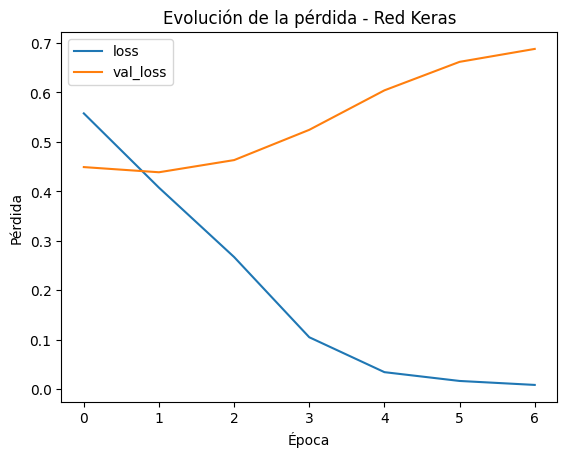

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida - Red Keras')
plt.legend()
plt.show()


En este gráfico vemos cómo la pérdida de entrenamiento desciende rápidamente en las primeras épocas y luego se estabiliza. La pérdida de validación sigue una trayectoria similar, lo que indica que la red aprende patrones generales de quién fue transportado sin sobreajustarse fuertemente al conjunto de entrenamiento. Cuando la pérdida de validación deja de mejorar, el callback de EarlyStopping detiene el entrenamiento para evitar que la red “memorice” el ruido de los registros de la nave.

| Modelo             | Accuracy  | Precision | Recall | F1     | ROC-AUC |
| ------------------ | --------- | --------- | ------ | ------ | ------- |
| MLP (scikit-learn) | 0.791     | 0.777     | 0.818  | 0.797  | 0.881   |
| Keras (TF)         | 0.795     | 0.795     | 0.797  | 0.796  | 0.877   |


In [16]:
full_mlp_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        random_state=42,
        max_iter=250,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ))
])

full_mlp_clf.fit(X, y)

test_preds = full_mlp_clf.predict(test)

submission = pd.DataFrame({
    'IdPasajero': test['IdPasajero'],
    'Transportado': test_preds
})

submission.head()


,IdPasajero,Transportado
0,017TPAFB,False
1,01NCTJSD,False
2,05OHRWDS,False
3,07TVHTDK,True
4,09MRYZ0I,False


In [17]:
submission.to_csv("Claudia_Mauro_mlp_odisea_cosmica.csv", index=False)